Рассмотрим начально-краевую задачу для одномерного уравнения теплопроводности:

$$
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2}
$$


c краевыми условиями $(t \geqslant 0)$

$$
u(0, t) = u(1, t) = 0
$$

и начальным условием $(0 < x < 1)$

$$
u(x, 0) = \sin{\pi x} \;.
$$

Требуется написать программу, строящую решение в области $0 \leqslant x \leqslant 1$ и $t \geqslant 0$ с использованием конечно-разностной неявной схемы на четырехточечном шаблоне.

Решение визуализировать, сравнить с точным решением.

Рассчитать порядок точности схемы и сравнить с порядком аппроксимации.

*Решение:*

In [27]:
import numpy as np
from scipy.linalg import solve_banded
import matplotlib.pyplot as plt

Начальное условие:

In [28]:
u_0 = lambda x: np.sin(np.pi * x)

Зададим область решения и шаги сетки по пространству и времени:

In [29]:
K = 2 # ограничение по времени
h = 0.005
tau = 0.01
x_space = np.arange(0, 1 + h, h)
t_space = np.arange(0, K + tau, tau)

Неявная схема является абсолютно устойчивой, поэтому здесь не нужно подбирать $ \tau $ в зависимости от $ h $ и наоборот.

In [30]:
T, X = np.meshgrid(t_space, x_space)

Зададим массив для аппрокмирующей функции на сетке, а также инициализируем значения, соответствующие граничным условиям:

In [31]:
y = np.empty_like(X)
y[:, 0] = u_0(X[:, 0])
y[0, :] = 0
y[-1, :] = 0

Определим функцию, реализирующую неявный шаблон:

In [32]:
def implicit_stencil(grid, tau, h):
    y = grid.copy()
    N = y.shape[0] - 1
    gamma = tau/h**2
    for j in range(1, y.shape[1]):
        ab = np.zeros((3, N-1))
        ab[0, 1:] = gamma
        ab[1, :] = -(1 + 2 * gamma)
        ab[2, :-1] = gamma

        b = -y[1:-1, j-1]
        b[0] -= gamma * y[0, j]
        b[-1] -= gamma * y[-1, j]
        
        y[1:-1, j] = solve_banded((1, 1), ab, b)
    return y

Аппроксимируем функцию:

In [33]:
y_val = implicit_stencil(y, tau, h)
print(y_val)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.57073173e-02 1.42963529e-02 1.30121332e-02 ... 1.26620437e-10
  1.15246316e-10 1.04893914e-10]
 [3.14107591e-02 2.85891783e-02 2.60210558e-02 ... 2.53209633e-10
  2.30464196e-10 2.09761947e-10]
 ...
 [3.14107591e-02 2.85891783e-02 2.60210558e-02 ... 2.53209633e-10
  2.30464196e-10 2.09761947e-10]
 [1.57073173e-02 1.42963529e-02 1.30121332e-02 ... 1.26620437e-10
  1.15246316e-10 1.04893914e-10]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


Аналитическим решением исходной задачи:  
$$
\begin{cases} 
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} \\
u(0, t) = u(1, t) = 0 \\
u(x, 0) = \sin{\pi x} 
\end{cases}
$$ 

является функция:
$$ u(x, t) = e^{-\pi^2 t} \sin(\pi x)$$

Зададим эту функцию и таблицу её значений:

In [34]:
u = lambda x, t: np.exp(-np.pi**2 * t) * np.sin(np.pi * x)
u_val = u(X, T)

Отобразим истинную и приближённые функции на графиках:

In [35]:
def plot_3d_subplots(X, T, u_val, y): 
    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(X, T, u_val)
    ax.view_init(30, 150)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')
    ax.set_title('Истинная функция')

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.plot_surface(X, T, y)
    ax.view_init(30, 150)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('y')
    ax.set_title('Аппроксимация')

    plt.show()

In [36]:
plot_3d_subplots(X, T, u_val, y_val)

ValueError: Unknown projection '3d'

<Figure size 1440x576 with 0 Axes>

Посчитаем ошибку: возьмём максимальный модуль разности значений истинной функции и функции-приближения:

In [37]:
np.max(np.abs(u_val - y_val))

0.017442882058256337

Известно, что порядок сходимости неявного метода - это $ O(\tau + h^{2}) $. Проверим это экспериментально.  
Определим функцию, которая по заданным $ \tau $ и $ h $ строит сетку, аппроксимирует функцию и возвращает ошибку (максимум модуля разности истинной функции и приближения):

In [38]:
def calc_error(tau, h, K=2):
    x_space = np.arange(0, 1 + h, h)
    t_space = np.arange(0, K + tau, tau)
    
    T, X = np.meshgrid(t_space, x_space)
    y = np.empty_like(X)
    y[:, 0] = u_0(X[:, 0])
    y[0, :] = 0
    y[-1, :] = 0

    y = implicit_stencil(y, tau, h)
    u_val = u(X, T)
    return np.max(np.abs(u_val - y))

Зафиксируем $ \tau $ и будем последовательно менять $ h $:

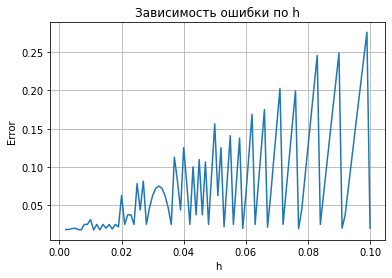

In [39]:
h = 0.2e-1
tau = 1e-2

h_range = np.arange(0.1, 0.001, -0.001)
error_list = []
for h_ in h_range:
    error_list.append(calc_error(tau, h_))

plt.plot(h_range, error_list)
plt.xlabel('h')
plt.ylabel('Error')
plt.title('Зависимость ошибки по h')
plt.grid()
plt.show()

Видно, что ошибка имеет квадратичный порядок по $ h $.  
Аналогично для $ \tau $ :

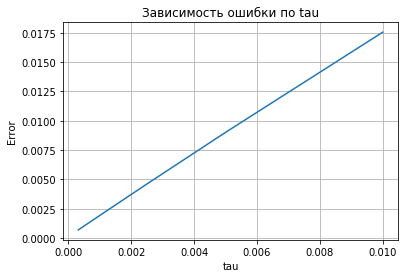

In [40]:
h = 0.2e-1
tau = 1e-2

tau_range = [tau/2**i for i in range(0, 6)]
error_list = []
for tau_ in tau_range:
    error_list.append(calc_error(tau_, h))

plt.plot(tau_range, error_list)
plt.xlabel('tau')
plt.ylabel('Error')
plt.title('Зависимость ошибки по tau')
plt.grid()
plt.show()

По $ \tau $ имеем линейный порядок ошибки.